8.2.2 Downloading the data

In [1]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
# criamos novo diretorio para armazenar dataset pequeno
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
	for category in ("cat", "dog"):
		dir = new_base_dir / subset_name / category
		os.makedirs(dir)
		fnames = [f"{category}.{i}.jpg"
				for i in range(start_index, end_index)]
		for fname in fnames:
			shutil.copyfile(src=original_dir / fname,
							dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)


We now have 2,000 training images, 1,000 validation images, and 2,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.

because we’re dealing with bigger images and a more complex problem, we’ll make our model larger, accordingly: it will have two more Conv2D and MaxPooling2D stages. This serves both to augment the capacity of the model and to further reduce the size of the feature maps so they aren’t overly large when we reach the Flatten layer. Here, because we start from inputs of size 180 pixels × 180 pixels (a somewhat arbitrary choice), we end up with feature maps of size 7 × 7 just before the Flatten layer.

Because we’re looking at a binary-classification problem, we’ll end the model with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the model is looking at one class or the other.

 One last small difference: we will start the model with a Rescaling layer, which will rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range

In [3]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(180, 180, 3))
#rescale inputs to the [0, 1] range by dividing them by 255
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2) (x)
x = layers.Conv2D(filters = 64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten() (x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


### 8.2.4 Data preprocessing

Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:
 - 1 Read the picture files.
 - 2 Decode the JPEG content into RGB grids of pixels.
 - 3 Convert these into floating-point tensors.
 - 4 resize them to a shared size (180, 180 in this case)
 - 5 pack them into batches (32 images in this case)



Using image_dataset_from_directory to read images

In [6]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
	new_base_dir / "train",
	image_size=(180, 180),
	batch_size=32,
)

validation_dataset = image_dataset_from_directory(
	new_base_dir / "validation",
	image_size=(180, 180),
	batch_size=32,
)
test_dataset = image_dataset_from_directory(
	new_base_dir / "test",
	image_size=(180, 180),
	batch_size=32,
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [7]:
for data_batch, labels_batch in train_dataset:
	print("data batch shape:", data_batch.shape)
	print("labels batch shape:", labels_batch.shape)
	break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Let’s fit the model on our dataset. We’ll use the validation_data argument in fit() to monitor validation metrics on a separate Dataset object

we’ll also use a ModelCheckpoint callback to save the model after each epoch. We’ll configure it with the path specifying where to save the file, as well as the arguments save_best_only=True and monitor="val_loss": they tell the callback to only save a new file (overwriting any previous one) when the current value of the val_loss metric is lower than at any previous time during training.

In [9]:
callbacks = [
	keras.callbacks.ModelCheckpoint(
		filepath="convnet_from_scratch.keras",
		save_best_only=True,
		monitor="val_loss"
	)
]

history = model.fit(
	train_dataset,
	epochs=30,
	validation_data=validation_dataset,
	callbacks=callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 380ms/step - accuracy: 0.5005 - loss: 0.7000 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5245 - loss: 0.6941 - val_accuracy: 0.5420 - val_loss: 0.6842
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.5830 - loss: 0.6799 - val_accuracy: 0.5970 - val_loss: 0.6517
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 377ms/step - accuracy: 0.6255 - loss: 0.6595 - val_accuracy: 0.6420 - val_loss: 0.6366
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 390ms/step - accuracy: 0.6745 - loss: 0.6182 - val_accuracy: 0.6750 - val_loss: 0.5984
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 378ms/step - accuracy: 0.6895 - loss: 0.5874 - val_accuracy: 0.7090 - val_loss: 0.5711
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step - accuracy: 0.7165 - loss: 0.5621 - val_accuracy: 0.5360 - val_loss: 1.0899
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - accuracy: 0.7400 - loss: 0.5222 - val_accu

Listing 8.12 Displaying curves of loss and accuracy during training

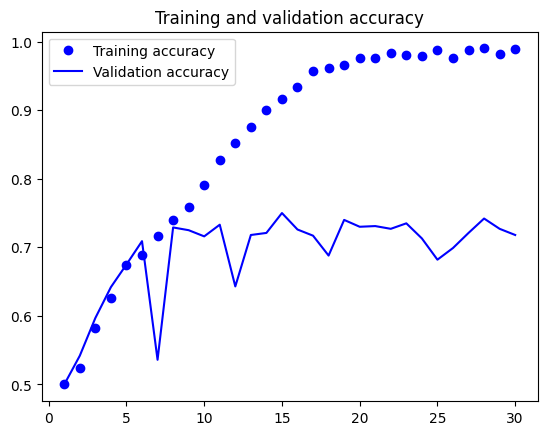

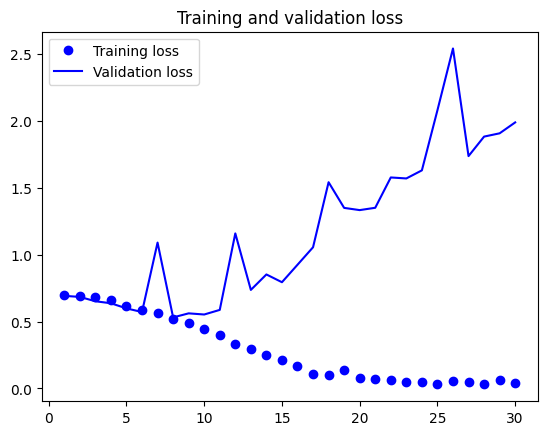

In [11]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


Let’s check the test accuracy. We’ll reload the model from its saved file to evaluate it as it was before it started overfitting.

In [12]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.7025 - loss: 0.5709
Test accuracy: 0.702


o modelo esta realizando overfitting, You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep learning models: *data augmentation*.

Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that, at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data so it can generalize better.

#### In Keras, this can be done by adding a number of data augmentation layers at the start of your model.

In [13]:
data_augmentation = keras.Sequential (
	[
		layers.RandomFlip("horizontal"),
		layers.RandomRotation(0.1),
		layers.RandomZoom(0.2),
	]
)

because they come from a small number of original images—we can’t produce new information; we can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, we’ll also add a Dropout layer to our model right before the densely connected classifier.

One last thing you should know about random image augmentation layers: just like Dropout, they’re inactive during inference (when we call predict() or evaluate()). During evaluation, our model will behave just the same as when it did not include data augmentation and dropout.

### Defining a new convnet that includes image augmentation and dropout

In [14]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Because we expect overfitting to occur much later during training, we will train for three times as many epochs—one hundred

In [15]:
callbacks = [
	keras.callbacks.ModelCheckpoint(
		filepath="convnet_from_scratch_with_augmentation.keras",
		save_best_only=True,
		monitor="val_loss"
	)
]
history = model.fit(
	train_dataset,
	epochs=100,
	validation_data=validation_dataset,
	callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - accuracy: 0.5000 - loss: 0.7259 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 449ms/step - accuracy: 0.4985 - loss: 0.6980 - val_accuracy: 0.5080 - val_loss: 0.6901
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 447ms/step - accuracy: 0.5290 - loss: 0.6951 - val_accuracy: 0.5040 - val_loss: 0.6924
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - accuracy: 0.5315 - loss: 0.6929 - val_accuracy: 0.6280 - val_loss: 0.6859
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 410ms/step - accuracy: 0.5740 - loss: 0.6867 - val_accuracy: 0.6360 - val_loss: 0.6602
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 466ms/step - accuracy: 0.6025 - loss: 0.6629 - val_accuracy: 0.6250 - val_loss: 0.6487
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 494ms/step - accuracy: 0.6185 - loss: 0.6583 - val_accuracy: 0.6300 - val_loss: 0.6487
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 438ms/step - accuracy: 0.6390 - loss: 0.6370 - 

lets plot the results again

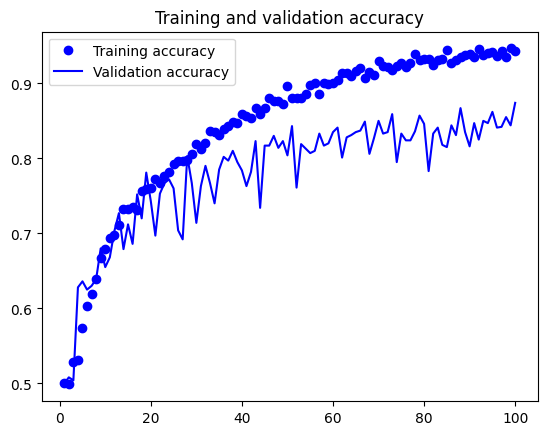

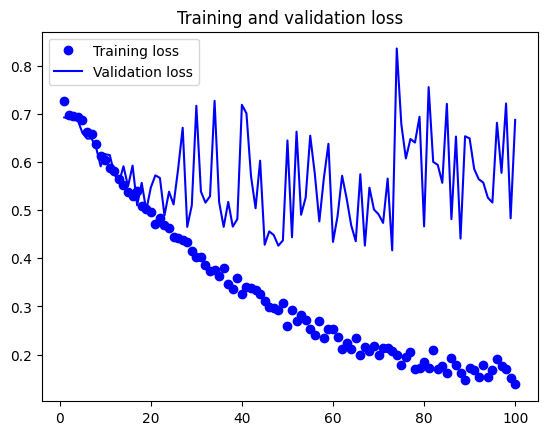

In [16]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

The validation accuracy ends up consistently in the 80–85% rangea big improvement over our first try. Let’s check the test accuracy.

In [17]:
test_model = keras.models.load_model(
	"convnet_from_scratch_with_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.8535 - loss: 0.4888
Test accuracy: 0.854


By further tuning the model’s configuration (such as the number of filters per convolution layer, or the number of layers in the model), we might be able to get an even better accuracy, likely up to 90%. But it would prove difficult to go any higher just by training our own convnet from scratch, because we have so little data to work with. As a next step to improve our accuracy on this problem, we’ll have to use a pretrained model, which is the focus of the next two sections.

### There are two ways to use a pretrained model: feature extraction and fine-tuning. We’ll cover both of them. Let’s start with feature extraction.

### Feature extraction with a pretrained model

As you saw previously, convnets used for image classification comprise two parts:

they start with a series of pooling and convolution layers, and they end with a densely connected classifier

because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. Let’s put this into practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features. 

In [18]:
conv_base = keras.applications.vgg16.VGG16(
	weights="imagenet",
	include_top=False,
	input_shape=(180, 180, 3)
)
#weights specifies the weight checkpoint from which to initialize the model.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


input_shape is the shape of the image tensors that we’ll feed to the network. This argument is purely optional: if we don’t pass it, the network will be able to process inputs of any size. Here we pass it so that we can visualize (in the following summary) how the size of the feature maps shrinks with each new convolution and pooling layer.

In [19]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

- Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier similar to those you saw in chapter 4 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow us to use data augmentation.

- Extend the model we have (conv_base) by adding Dense layers on top, and run the whole thing from end to end on the input data. This will allow us to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

### FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
	all_features = []
	all_labels = []
	for images, labels in dataset:
		preprocessed_images = keras.applications.vgg16.preprocess_input(images)
		features = conv_base.predict(preprocessed_images)
		all_features.append(features)
		all_labels.append(labels)
	return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

Importantly, predict() only expects images, not labels, but our current dataset yields batches that contain both images and their labels. Moreover, the VGG16 model expects inputs that are preprocessed with the function keras.applications.vgg16.preprocess_input, which scales pixel values to an appropriate range

#### The extracted features are currently of shape (samples, 5, 5, 512)

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
	keras.callbacks.ModelCheckpoint(
		filepath="feature_extraction.keras",
		save_best_only=True,
		monitor="val_loss"
	)
]

history = model.fit(
	train_features, train_labels,
	epochs=30,
	validation_data=(val_features, val_labels),
	callbacks=callbacks
)
#Training is very fast because we only have to deal with two Dense layers

#### plotting the results

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


We reach a validation accuracy of about 97%. However, the plots also indicate that we’re overfitting almost from the startdespite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

#### FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION

In order to do this, we will first freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don’t do this, the representations that were previously learned by the convolutional base will be modified during training.

In [ ]:
### instantiate the VGG16 convolutional base and freeze it
conv_base = keras.applications.vgg16.VGG16(
	weights="imagenet",
	include_top=False,
)
conv_base.trainable = False



Now we can create a new model that chains together 
 - 1 A data augmentation stage
 - 2 Our frozen convolutional base 
 - 3 A dense classifier

In [ ]:
data_augmentation = keras.Sequetial(
	[
		layers.RandomFlip("horizontal"),
		layers.RandomRotation(0.1),
		layers.RandomZoom(0.2),
	]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x) #apply the same preprocessing as during the vgg16 training
x = conv_base(x)

x = layers.Flatten()(x)
x  = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
	keras.callbacks.ModelCheckpoint(
		filepath="feature_extraction_with_data_augmentation.keras",
		save_best_only=True,
		monitor="val_loss"
	)
]

Let’s train our model. Thanks to data augmentation, it will take much longer for the model to start overfitting, so we can train for more epochs—let’s do 50.

In [ ]:
history = model.fit(
	train_dataset,
	epochs=50,
	validation_data=validation_dataset,
	callbacks=callbacks
)

In [ ]:
#plotting the results
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model(
	"feature_extraction_with_data_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


We get a test accuracy of 97.5%. This is only a modest improvement compared to the previous test accuracy, which is a bit disappointing given the strong results on the validation data. A model’s accuracy always depends on the set of samples you evaluate it on! Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets.

### 8.3.2 Fine-tuning a pretrained model

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers.

the steps for fine-tuning a network are as follows:  1 Add our custom network on top of an already-trained base network. 2 Freeze the base network. 3 Train the part we added. 4 Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on finetuning is explained in the next chapter.) 5 Jointly train both these layers and the part we added.

Thus the steps for fine-tuning a network are as follows:  
- 1 Add our custom network on top of an already-trained base network. 
- 2 Freeze the base network. 
- 3 Train the part we added.
- 4 Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on finetuning is explained in the next chapter.) 
- 5 Jointly train both these layers and the part we added.

You already completed the first three steps when doing feature extraction. Let’s proceed with step 4: we’ll unfreeze our conv_base and then freeze individual layers inside it.


In [ ]:
conv_base.summary()

We’ll fine-tune the last three convolutional layers, which means all layers up to block4_ pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
	layer.trainable = False

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
	keras.callbacks.ModelCheckpoint(
		filepath="fine_tuning.keras",
		save_best_only=True,
		monitor="val_loss"
	)
]

history = model.fit(
	train_dataset,
	epochs=30,
	validation_data=validation_dataset,
	callbacks=callbacks
)



We can finally evaluate this model on the test data:

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")